# MindSpore Challenge Tutorial (Beginner)

Throughout this tutorial we will cover [MindSpore](https://www.mindspore.cn/doc/api_python/en/r1.2/index.html)'s common modules
- MindSpore Dataset [mindspore.dataset][ms dataset]
- MindSpore Neural Network [mindspore.nn][ms nn]
- MindSpore Operators [mindspore.ops][ms ops]
- Training and creating MindSpore Models.

Prerequisite:
- Understanding of Python and Python common packages
- Understanding of operations and  of common machine learning libraries (Nice to have)
- Understanding of designing, training, evaluation of machine learning libraries (Nice to have)

We will be referencing from [MindSpore Course](https://www.mindspore.cn/tutorial/zh-CN/r1.2/quick_start.html)'s LeNet5 on MNIST Dataset

[ms dataset]: https://www.mindspore.cn/doc/api_python/en/r1.2/mindspore/mindspore.dataset.html
[ms nn]: https://www.mindspore.cn/doc/api_python/en/r1.2/mindspore/mindspore.nn.html
[ms ops]: https://www.mindspore.cn/doc/api_python/en/r1.2/mindspore/mindspore.ops.html

## Obtaining notebook https://github.com/MindSporeChallenge21/notebook
Visit the link above to download this notebook so you can try on your own.

## Importing Libraries

In [1]:
from pathlib import Path
import json
from copy import copy

import math
import pandas as pd
import numpy as np
from easydict import EasyDict as ed
from scipy import interpolate

import requests

import mindspore as ms
from mindspore import nn
from mindspore.common.initializer import Normal
from mindspore import dataset

import cv2
from PIL import Image
from skimage.io import imread_collection

from matplotlib import pyplot as plt
import seaborn as sns

## MindSpore Basics

1. Creating a [MindSpore Dataset][ms dataset] object
2. Creating a [MindSpore Neural Network][ms nn]
3. Training the [MindSpore Neural Network][ms nn]

[ms dataset]: https://www.mindspore.cn/doc/api_python/en/r1.2/mindspore/mindspore.dataset.html
[ms nn]: https://www.mindspore.cn/doc/api_python/en/r1.2/mindspore/mindspore.nn.html
[ms ops]: https://www.mindspore.cn/doc/api_python/en/r1.2/mindspore/mindspore.ops.html

## MindSpore Context

You need to specify the type of the backend you are going to use, namely: `CPU`, `GPU`, `Ascend`.

`Ascend` is a Neural Processing Unit(NPU) developed by Huawei, it will significantly speed up the process of training a model, which we will try later.

For the mode of execution, there is two choices, `GRAPH_MODE` or `PYNATIVE_MODE`.

`GRAPH_MODE` are designed for training purposes, with faster execution performance, but is generally harder for development.

`PYNATIVE_MODE` are design for development purposes, with slower execution performance, but allows neural network to easily modified.

For more information see [`mindspore.context.set_context`](https://www.mindspore.cn/doc/api_python/en/r1.2/mindspore/mindspore.context.html)

In [2]:
ms.context.set_context(device_target='CPU', mode=ms.context.PYNATIVE_MODE)


## Downloading MNIST Data and creating a MindSpore Dataset object.

We can create a MindSpore Dataset object with the [mindspore.dataset][ms dataset] module. 

There is a [MnistDataset][ms mnist dataset] class for importing MnistDatasets.

[ms dataset]: https://www.mindspore.cn/doc/api_python/en/r1.2/mindspore/mindspore.dataset.html
[ms mnist dataset]: https://www.mindspore.cn/doc/api_python/zh-CN/r1.2/mindspore/dataset/mindspore.dataset.MnistDataset.html#mindspore.dataset.MnistDataset

In [3]:
!mkdir -p ./datasets/MNIST_Data/train ./datasets/MNIST_Data/test
!wget -NP ./datasets/MNIST_Data/train https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-labels-idx1-ubyte
!wget -NP ./datasets/MNIST_Data/train https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-images-idx3-ubyte
!wget -NP ./datasets/MNIST_Data/test https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-labels-idx1-ubyte
!wget -NP ./datasets/MNIST_Data/test https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-images-idx3-ubyte


--2021-08-24 16:39:21--  https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-labels-idx1-ubyte
Resolving mindspore-website.obs.myhuaweicloud.com (mindspore-website.obs.myhuaweicloud.com)... 49.4.112.91, 49.4.112.92, 49.4.112.3
Connecting to mindspore-website.obs.myhuaweicloud.com (mindspore-website.obs.myhuaweicloud.com)|49.4.112.91|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘./datasets/MNIST_Data/train/train-labels-idx1-ubyte’ not modified on server. Omitting download.

--2021-08-24 16:39:21--  https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-images-idx3-ubyte
Resolving mindspore-website.obs.myhuaweicloud.com (mindspore-website.obs.myhuaweicloud.com)... 49.4.112.91, 49.4.112.92, 49.4.112.3
Connecting to mindspore-website.obs.myhuaweicloud.com (mindspore-website.obs.myhuaweicloud.com)|49.4.112.91|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘./datasets/MNIST_

In [4]:
mnist_dataset_path = Path('datasets') / 'MNIST_Data'

mnist_train_dataset_path = mnist_dataset_path / 'train'
mnist_test_dataset_path = mnist_dataset_path / 'test'

In [5]:
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV

# creating a mindspore dataset
def create_dataset(mnist_dataset_path, batch_size=32, num_parallel_workers=2):
    
    # use MnistDataset to read the donwloaded data
    dataset = ms.dataset.MnistDataset(str(mnist_train_dataset_path))
    
    # define variables
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0

    # define operations
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()
    type_cast_op = C.TypeCast(ms.dtype.int32)

    # labels to int32
    dataset = dataset.map(
        operations=type_cast_op, 
        input_columns="label", 
        num_parallel_workers=num_parallel_workers
    )
    
    # image values to [0,1]
    # image from HWC to CHW  <- requirements for convolution
    dataset = dataset.map(
        operations=[rescale_op, hwc2chw_op], 
        input_columns="image", 
        num_parallel_workers=num_parallel_workers
    )
    
    # perform shuffling and batching
    buffer_size = 10000
    dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    
    return dataset

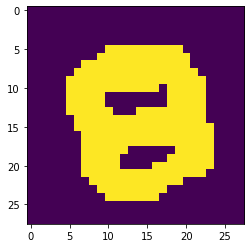

In [6]:
mnist_train_ds = create_dataset(mnist_train_dataset_path, 32)
mnist_test_ds = create_dataset(mnist_test_dataset_path, 32)

for i in mnist_train_ds.create_dict_iterator():
    plt.imshow(i['image'].asnumpy()[0,0])
    break

In [7]:
print('Train Dataset Size:', mnist_train_ds.get_dataset_size(), 'Testing Dataset Size:', mnist_test_ds.get_dataset_size())

Train Dataset Size: 1875 Testing Dataset Size: 1875


## Defining a Neural Network (LeNet5)

![](https://segmentfault.com/img/remote/1460000023074059)

1. 2 Convolution layer (kernel: 5x5)
2. 3 Dense layer of

To define network we need to define a class which extends `nn.Cell`.

This class have two parts, the `__init__` and the `construct` function:
- `__init__` all neural network operators will be defined in this function.
- `construct` all neural network graph will be defined in this function.

The common neural network layers are the `mindspore.nn.Conv2D`, `mindspore.nn.Dense`, to use them correctly user are required to define the input and output channels/nodes for these function.

The [mindspore.nn.Conv2d](https://www.mindspore.cn/doc/api_python/en/r1.2/mindspore/nn/mindspore.nn.Conv2d.html#mindspore.nn.Conv2d) requires the **kernel size**, the **input channel** and **output channel** sizes. The input channels are based on the number of channels in the images or in the intermediate steps, and the output channels can be freely defined. 

The [mindspore.nn.Dense](https://www.mindspore.cn/doc/api_python/en/r1.2/mindspore/nn/mindspore.nn.Dense.html#mindspore.nn.Dense) (Fully connected layers) requires the **numbers of input node** and the **numbers of output nodes**. The number of input nodes are based on the nodes in the previous layers, usually we will be flattening the results from the convolution layers and pooling layers to use in the dense layer, some calculation maybe needed to find the number of nodes after the flattenning result, usually this is the number of channels * the width and height of each channels. 

Other common operators can be found in the [following list](https://www.mindspore.cn/doc/api_python/en/r1.2/mindspore/mindspore.nn.html#).

In [8]:
from mindspore import nn
from mindspore.common.initializer import Normal

In [9]:

input_image_shape = 28 # assume image is square

class LeNet5(nn.Cell):
    
    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5, self).__init__()
        
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')  # stride is 1
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid') 
        
        self.fc1 = nn.Dense(16 * 4 * 4, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        
        self.shape = ms.ops.Shape()
        self.print = ms.ops.Print()

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x) # this operation is static, so we can use it multiple times
        x = self.max_pool2d(x)  # this operation is static, so we can use it multiple times
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# creating an instance of LeNet5
net = LeNet5()

_To use these operations, one may need to understand how to calculate the number of nodes after convolution steps, moreover, you can use the [`mindspore.ops.Shape`](https://www.mindspore.cn/doc/api_python/en/r1.2/mindspore/ops/mindspore.ops.Shape.html#mindspore.ops.Shape) and [`mindspore.ops.Print`](https://www.mindspore.cn/doc/api_python/en/r1.2/mindspore/ops/mindspore.ops.Print.html#mindspore.ops.Print) to find out the shapes of the outputs._

Knowing how to do the math for calculating number of nodes/image size are very useful to have a deep understanding of the convolution steps and fully-connected steps.

You might confused on how `16 * 4 * 4` is used as the input of the first dense layer.

The below class calculates the input and output channels and nodes dynamically and design the model that way.

In [10]:
input_image_shape = 28 # assume image is square

class LeNet5_dynamic(nn.Cell):
    
    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5_dynamic, self).__init__()
        
        conv_channels_1 = 6
        conv_channels_2 = 16
        
        kernel_size_1 = kernel_size_2 = 5
        
        self.conv1 = nn.Conv2d(num_channel, conv_channels_1, kernel_size_1, pad_mode='valid')  # stride is 1
        self.conv2 = nn.Conv2d(conv_channels_1, conv_channels_2, kernel_size_2, pad_mode='valid')  # stride is 1
        
        conv_output_size_1 = math.ceil((input_image_shape - (kernel_size_1-1)) / 1) # (input image shape - (kernel size - 1)) / stride
        max_pooling_output_size_1 = math.ceil((conv_output_size_1 - (2-1)) / 2) #  1 + (conv 1 image shape - (kernel size - 1)) / stride
        conv_output_size_2 = math.ceil((max_pooling_output_size_1 - (kernel_size_2-1)) / 1)  # 
        max_pooling_output_size_2 = math.ceil((conv_output_size_2 - (2-1)) / 2)  # 
        
        dense_nodes_1 = 120
        dense_nodes_2 = 84
        
        self.fc1 = nn.Dense(conv_channels_2 * max_pooling_output_size_2 * max_pooling_output_size_2, dense_nodes_1, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(dense_nodes_1, dense_nodes_2, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(dense_nodes_2, num_class, weight_init=Normal(0.02))
        
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        
        self.shape = ms.ops.Shape()
        self.print = ms.ops.Print()

    def construct(self, x):
        
        x = self.conv1(x)
        x = self.relu(x)
        self.print(self.shape(x))  # use print and shape to find out the shape if you are uncertain.
        
        x = self.max_pool2d(x)
        self.print(self.shape(x))
        
        x = self.conv2(x)
        x = self.relu(x)  
        self.print(self.shape(x))
        
        x = self.max_pool2d(x) # this operation is static, so we can use it multiple times
        self.print(self.shape(x))
        
        x = self.flatten(x)
        
        self.print(self.shape(x))
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [11]:
net(i['image'])

Tensor(shape=[32, 10], dtype=Float32, value=
[[ 2.91483193e-05, -4.27754549e-06,  2.95517361e-06 ...  9.11741367e-08, -1.25127917e-05, -6.28899079e-06],
 [ 3.04563637e-05, -4.71644853e-06, -2.23849347e-05 ...  1.38128789e-05, -1.66006685e-05,  2.93739788e-08],
 [ 2.52394311e-05, -1.41289584e-05,  1.64396454e-06 ...  1.71922443e-06, -6.12040412e-06, -1.32128262e-05],
 ...
 [ 2.75114398e-05, -3.64461812e-06, -7.15348460e-06 ... -1.04310050e-06, -9.15611326e-06, -5.34610172e-06],
 [ 3.38642640e-05,  4.48467699e-06, -5.02298053e-06 ... -1.01861297e-05, -6.05442256e-06, -8.73958470e-06],
 [ 2.12739924e-05, -8.54431346e-06,  1.08481709e-05 ...  1.04173314e-05, -3.89720253e-06, -1.01335017e-05]])

## Defining a Model

The models in MindSpore requires 3 parameters
- the network
- the optimizer [MindSpore Optimizer Functions](https://www.mindspore.cn/doc/api_python/zh-CN/r1.2/mindspore/mindspore.nn.html#optimizer-functions)
- the loss function [MindSpore Loss Functions](https://www.mindspore.cn/doc/api_python/zh-CN/r1.2/mindspore/mindspore.nn.html#loss-functions)

The optimizers is the method to reduces the loss, and the loss function measures the evaluation performance of the network.

The optimizers have one required parameters which is the network's parameters. These parameters, can be obtained by `net.trainable_params()`

In [12]:
loss = ms.nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
optimizers = ms.nn.Adam(net.trainable_params(), learning_rate=0.01)

model = ms.Model(
    net,
    loss,
    optimizers, 
    metrics={"Accuracy": ms.nn.Accuracy()}
)

## Training the model

We might want to monitor the _loss changes_, and _create checkpoints_ for model at few epoches.

In [13]:
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor

mnist_train_ds = create_dataset(mnist_train_dataset_path, 32)

# 设置模型保存参数
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
# 应用模型保存参数
ckpoint = ModelCheckpoint(prefix="checkpoint_lenet", directory='./checkpoints', config=config_ck)

model.train(epoch=5, train_dataset=mnist_train_ds, callbacks=[ckpoint, LossMonitor(125)])

[WARNING] ME(3023:139781394663040,MainProcess):2021-08-20-14:40:18.431.168 [mindspore/train/model.py:412] The CPU cannot support dataset sink mode currently.So the training process will be performed with dataset not sink.


epoch: 1 step: 125, loss is 0.521804
epoch: 1 step: 250, loss is 0.23421651
epoch: 1 step: 375, loss is 0.21887353
epoch: 1 step: 500, loss is 0.06689039
epoch: 1 step: 625, loss is 0.18427612
epoch: 1 step: 750, loss is 0.1372671
epoch: 1 step: 875, loss is 0.2118403
epoch: 1 step: 1000, loss is 0.0872464
epoch: 1 step: 1125, loss is 0.08675042
epoch: 1 step: 1250, loss is 0.2049871
epoch: 1 step: 1375, loss is 0.1300338
epoch: 1 step: 1500, loss is 0.09513578
epoch: 1 step: 1625, loss is 0.057195194
epoch: 1 step: 1750, loss is 0.060339466
epoch: 1 step: 1875, loss is 0.12788846
epoch: 2 step: 125, loss is 0.08784718
epoch: 2 step: 250, loss is 0.07043126
epoch: 2 step: 375, loss is 0.00695764
epoch: 2 step: 500, loss is 0.31245264
epoch: 2 step: 625, loss is 0.15288578
epoch: 2 step: 750, loss is 0.32073644
epoch: 2 step: 875, loss is 0.18298802
epoch: 2 step: 1000, loss is 0.09131481
epoch: 2 step: 1125, loss is 0.17523211
epoch: 2 step: 1250, loss is 0.17023318
epoch: 2 step: 1375

Few things to note here:
1. The `train_dataset`, expects the last column to be the labels. You can use `dataset.get_col_names()` to check which column is the lables.
2. Each each instance of dataset can only be used once. Therefore we put the create_dataset in this cell.

## Show results